In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('../'))
import interpretability.interp_helpers as interp

import utils.file_management as fm
import utils.parse_data as parse

%load_ext autoreload
%autoreload 2


In [2]:
sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 10,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

In [3]:
run = 36

In [4]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# run = fm.get_latest_run()
model, model_info, config = parse.load_trained_model(run, model_name=None, device=device, weights_only=False)

# Print number of parameters and important metadata
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Using cpu device
Total number of parameters: 292


In [5]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']

# Get common sequences from data for analysis
num_sequences = 200
events, sequences, counts = interp.get_common_sequences(T, run=run, k=num_sequences)
print(f"Analyzing {num_sequences} sequences:\n{sequences[:20]}")

Analyzing 200 sequences:
['LLLLLL', 'RRRRRR', 'LLLLLl', 'RRRRRr', 'LLLLlL', 'RRRRrR', 'LLLlLL', 'LLlLLL', 'RRRrRR', 'LlLLLL', 'RRrRRR', 'lLLLLL', 'RrRRRR', 'rRRRRR', 'rLLLLL', 'lRRRRR', 'rrLLLL', 'llRRRR', 'RRRRrr', 'LLLLll']


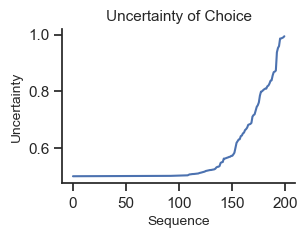

In [6]:
selected_sequences, uncertainty = interp.get_uncertain_sequences(sequences, model, feature='choice', is_uncertain=True, threshold=0)

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(uncertainty)
ax.set(title='Uncertainty of Choice', xlabel='Sequence', ylabel='Uncertainty')
sns.despine()

In [7]:
high_uncertainty_sequences, high_uncertainty = interp.get_uncertain_sequences(sequences, model, feature='choice', is_uncertain=True, threshold=0.7)
print(high_uncertainty_sequences[:10])

low_uncertainty_sequences, low_uncertainty = interp.get_uncertain_sequences(sequences, model, feature='choice', is_uncertain=False, threshold=0.7)
print(low_uncertainty_sequences[:10])


['LLLrrr', 'Llllll', 'RRRRll', 'rrrrRr', 'rrrRrr', 'LLLLLR', 'rrRrrr', 'rRrrrr', 'RRRlll', 'RRRRrL']
['LLLLLL', 'lLLLLL', 'RRRRRR', 'rRRRRR', 'LLLLrL', 'RrRRRR', 'LLLLlL', 'LLLrLL', 'LLLlLL', 'LLlLLL']


Text(0.5, 0.98, 'Choice Uncertainty')

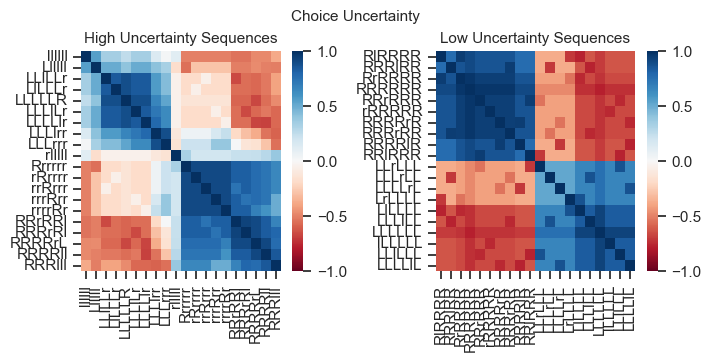

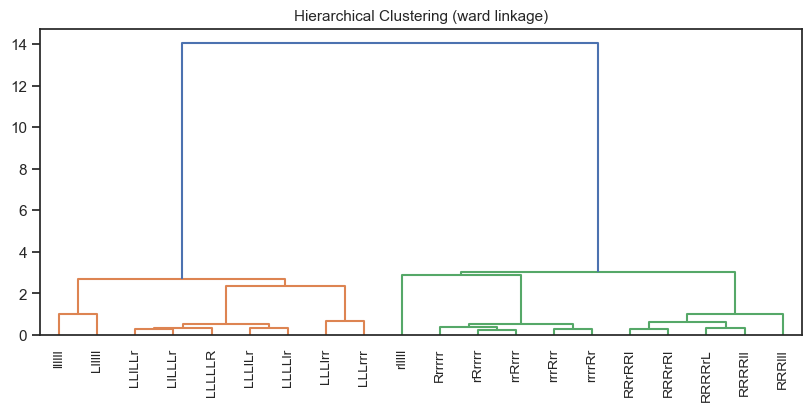

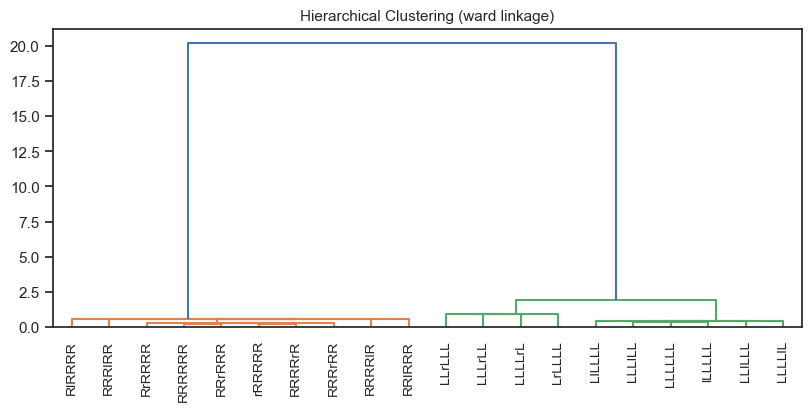

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(7, 3.5), layout='constrained')

_, similarities = interp.sequence_embedding_similarity(model, high_uncertainty_sequences[:20], stoi)
ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, high_uncertainty_sequences[:20], replot=False)
axs[0] = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=axs[0])
axs[0].set(title='High Uncertainty Sequences')

_, similarities = interp.sequence_embedding_similarity(model, low_uncertainty_sequences[:20], stoi)
ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, low_uncertainty_sequences[:20], replot=False)
axs[1] = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=axs[1])
axs[1].set(title='Low Uncertainty Sequences')
fig.suptitle('Choice Uncertainty')


In [9]:
high_overall_uncertainty_sequences, high_overall_uncertainty = interp.get_uncertain_sequences(sequences, model, is_uncertain=True, threshold=0.5)
print(high_uncertainty_sequences[:10])

low_overall_uncertainty_sequences, low_overall_uncertainty = interp.get_uncertain_sequences(sequences, model, is_uncertain=False, threshold=0.7)
print(low_uncertainty_sequences[:10])


['LLLrrr', 'Llllll', 'RRRRll', 'rrrrRr', 'rrrRrr', 'LLLLLR', 'rrRrrr', 'rRrrrr', 'RRRlll', 'RRRRrL']
['LLLLLL', 'lLLLLL', 'RRRRRR', 'rRRRRR', 'LLLLrL', 'RrRRRR', 'LLLLlL', 'LLLrLL', 'LLLlLL', 'LLlLLL']


Text(0.5, 0.98, 'Overall Uncertainty (including reward)')

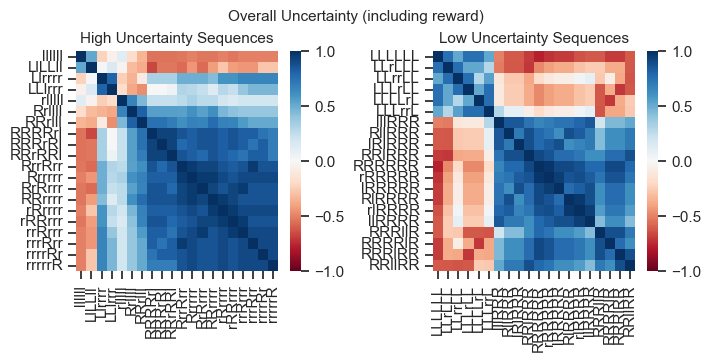

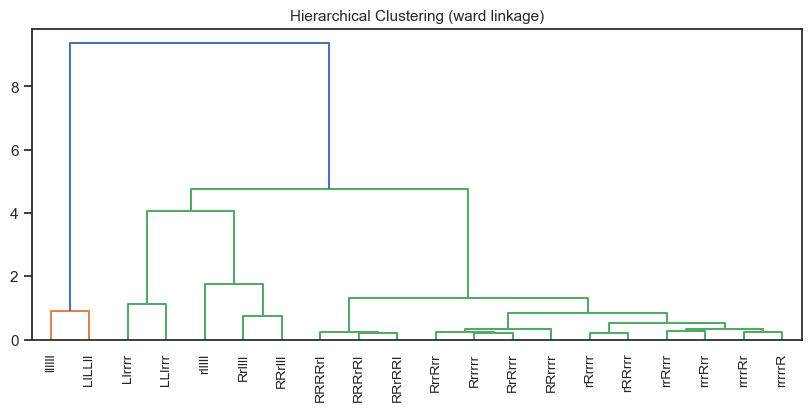

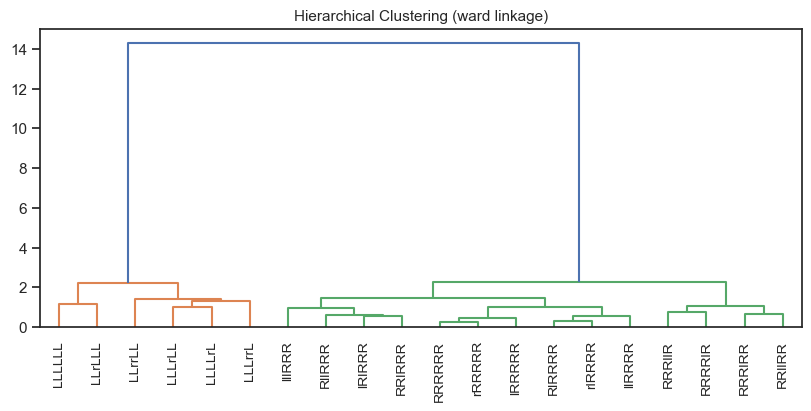

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(7, 3.5), layout='constrained')

_, similarities = interp.sequence_embedding_similarity(model, high_overall_uncertainty_sequences[:20], stoi)
ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, high_overall_uncertainty_sequences[:20], replot=False)
axs[0] = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=axs[0])
axs[0].set(title='High Uncertainty Sequences')

_, similarities = interp.sequence_embedding_similarity(model, low_overall_uncertainty_sequences[:20], stoi)
ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, low_overall_uncertainty_sequences[:20], replot=False)
axs[1] = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=axs[1])
axs[1].set(title='Low Uncertainty Sequences')
fig.suptitle('Overall Uncertainty (including reward)')

Raw weights: N dimensions for each token (fixed at 4 right now, single letter vocab) and T positions (sequence length)

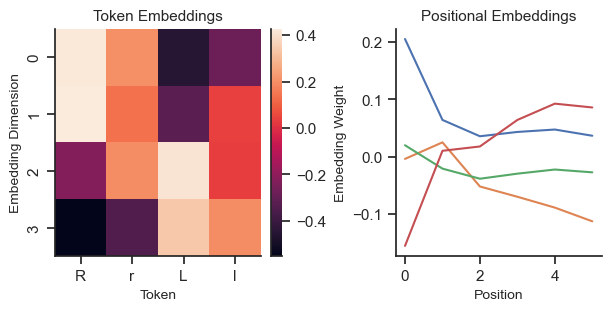

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 3), layout='constrained')
sns.heatmap(model.transformer.wte.weight.detach().cpu().numpy().T, ax=axs[0])
axs[0].set(title='Token Embeddings', xticklabels=vocab, xlabel='Token', ylabel='Embedding Dimension')
axs[1].plot(model.transformer.wpe.weight.detach().cpu().numpy())
axs[1].set(title='Positional Embeddings', xlabel='Position', ylabel='Embedding Weight')
sns.despine()


<Axes: >

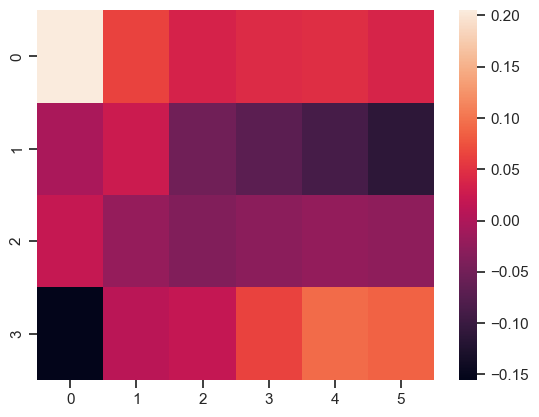

In [12]:
sns.heatmap(model.transformer.wpe.weight.detach().cpu().numpy().T)

### Starting by just looking at token embeddings
- What is the dimensionality of the token embeddings?
- Pairwise similarity between each of the token embeddings


Explained variance ratio: [9.2378461e-01 7.4650988e-02 1.5643967e-03 3.9824101e-17]
Cumulative explained variance: [0.9237846 0.9984356 1.        1.       ]


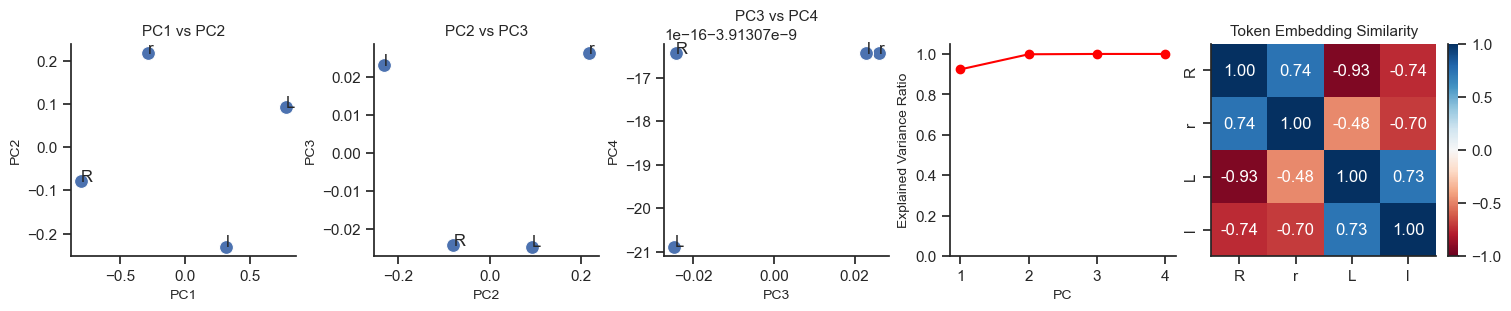

In [13]:
pca, embedded = interp.pca_embeddings(
    model, 
    n_components=4,
    token_mapping=stoi
)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

### Trajectory of learning this embedding space
Projecting token embeddings of each checkpoint into the embedding space (first 2 PCs) of the final trained model

Found 15 models for run 36


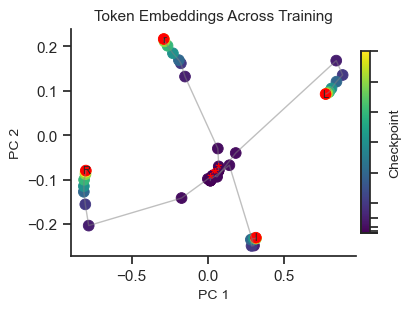

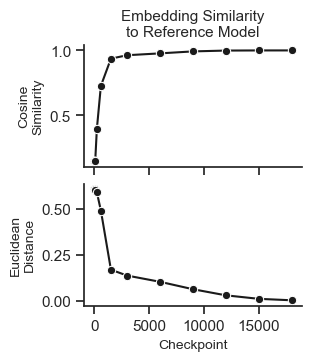

In [53]:
cp_data = interp.analyze_embedding_evolution(run)

In [56]:
sample_sequences = np.random.choice(sequences, size=20)

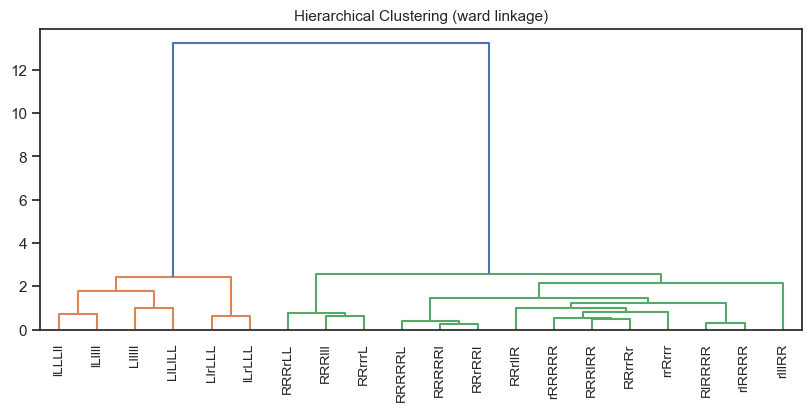

In [57]:
embeddings, similarities = interp.sequence_embedding_similarity(model, sample_sequences, stoi)

ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, sample_sequences, replot=False)

[Text(0.5, 1.0, 'run 36')]

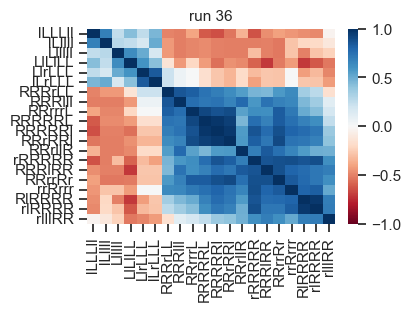

In [58]:
ax = interp.plot_similarity(ordered_sim_matrix, ordered_sequences)
ax.set(title=f'run {run}')

### Sequence similarity for validation specific sequences

In [59]:
import evaluation.inspect_data as inspect

In [60]:
model_name = model_info['model_name']
train_events = parse.parse_simulated_data(*parse.get_data_filenames(run, suffix='tr'))
aligned_data = parse.load_predictions(run, model_name, suffix='v')

maxT = model_info['dataloader']['Sequence length (T)']
minT = maxT

aligned_data = inspect.compare_train_val(run, train_events, aligned_data,
                                 maxT=maxT, minT=minT, show_plot=False)

val_unique_sequences = aligned_data.query('seq6_overlap == False')['seq6_RL'].value_counts()[:20].index

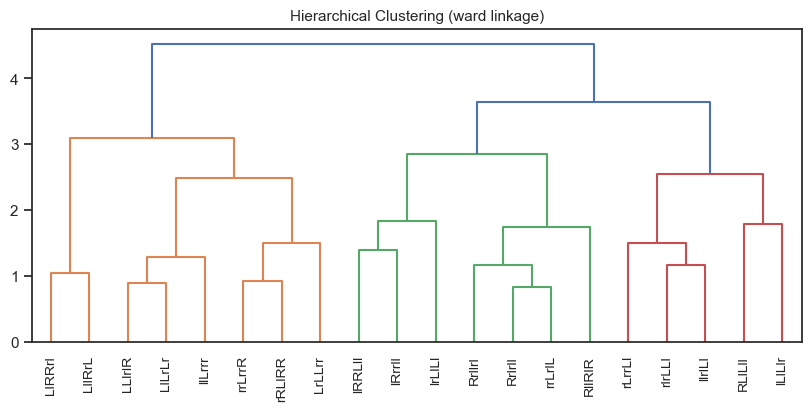

In [61]:
embeddings, similarities = interp.sequence_embedding_similarity(model, val_unique_sequences, stoi)

ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(similarities, val_unique_sequences, replot=False)

[Text(0.5, 1.0, 'Matched Sequences')]

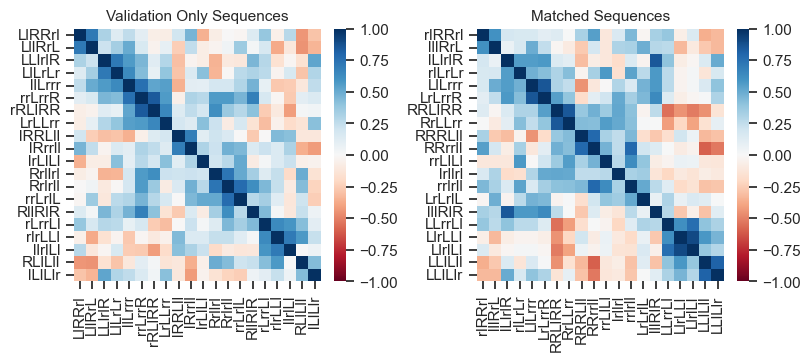

In [62]:
matched_sequences = inspect.match_by_base_sequence(aligned_data, ordered_sequences, base_T=5, min_count=20)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3.5), layout='constrained')

axs[0] = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=axs[0])
axs[0].set(title='Validation Only Sequences')

_, similarities = interp.sequence_embedding_similarity(model, matched_sequences, stoi)
axs[1] = interp.plot_similarity(similarities, matched_sequences, ax=axs[1])
axs[1].set(title='Matched Sequences')


## Comparing across different model architectures and task environments

Text(0.5, 0.98, 'Similarity Matrix (ordered by hierarchical clustering of first run)')

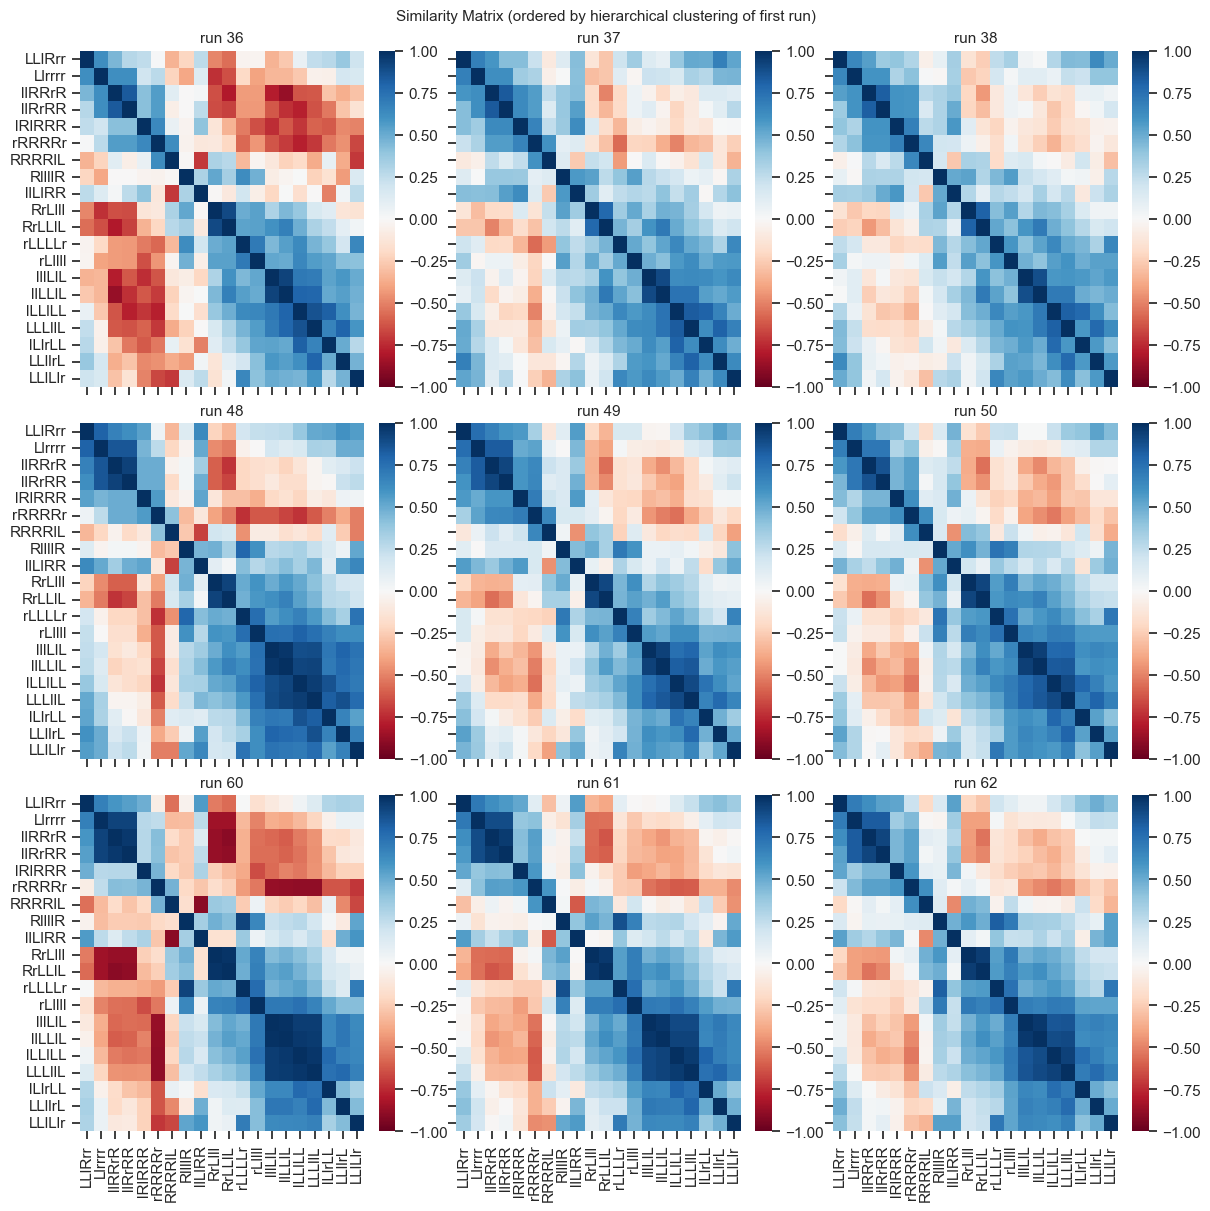

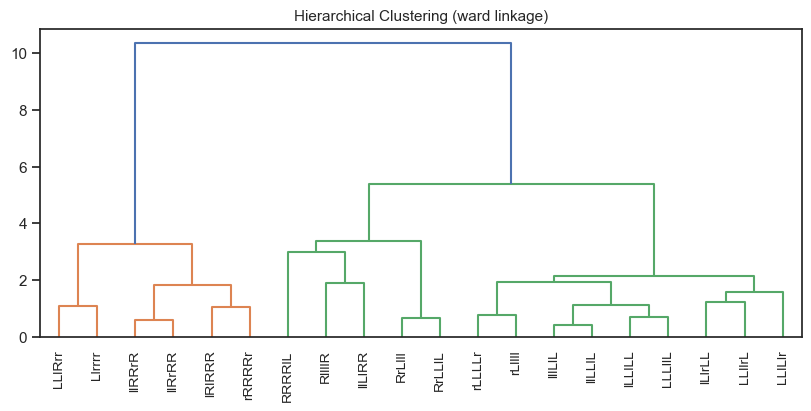

In [76]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12),
                        layout='constrained', sharex=True, sharey=True)

runs = [int(run.split('_')[1]) for run in os.listdir('../experiments') if run != '.DS_Store']

usable_runs = [36, 37, 38, 48, 49, 50, 60, 61, 62]
# usable_runs = []
if not usable_runs:
    for run in runs:
        model, model_info, config = parse.load_trained_model(run, model_name=None, device=device, weights_only=False)
        if T == model_info['dataloader']['Sequence length (T)']:
            usable_runs.append(run)
usable_runs = sorted(usable_runs)

for i, (run, ax) in enumerate(zip(usable_runs, axs.ravel())):

    model, model_info, config = parse.load_trained_model(run, model_name=None, device=device, weights_only=False)

    assert T == model_info['dataloader']['Sequence length (T)'], f"Sequence length mismatch for run {run}"
    events = parse.parse_simulated_data(*parse.get_data_filenames(run, suffix='v'))
    events = parse.add_sequence_columns(events, T)
    vc = events[f'seq{T}_RL'].value_counts()
    if i == 0:  # Use same sequences for all models
        sequences = vc[vc > 100].sample(n=20).index
        _, similarities = interp.sequence_embedding_similarity(model, sequences, stoi)
        ordered_sequences, ordered_sim_matrix, _ = interp.cluster_sequences_hierarchical(similarities, sequences, replot=False)
    else:
        _, ordered_sim_matrix = interp.sequence_embedding_similarity(model, ordered_sequences, stoi)

    ax = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=ax)
    ax.set(title=f'run {run}')

fig.suptitle('Similarity Matrix (ordered by hierarchical clustering of first run)')

In [77]:
usecols = [
    'model_id', 'domain_id',
       'num_samples', 'num_parameters', 'max_steps', 'run_number',
       'sequence_length', 'n_embd', 'epochs',
       'best_val_full_loss', 'best_val_full_loss_step', 'best_val_choice_loss',
       'best_val_choice_loss_step', 'best_val_reward_loss',
       'best_val_reward_loss_step'
]

model_summary = pd.read_csv('../model_summary.csv', usecols=usecols)
model_summary.query('sequence_length == 6')

model_summary.query('run_number in @usable_runs')[['run_number', 'model_id', 'domain_id', 'n_embd']]

,run_number,model_id,domain_id,n_embd
0,36,l1_h1_e100_c6_d4,A,4
1,37,l1_h1_e100_c6_d8,A,8
2,38,l1_h1_e100_c6_d16,A,16
12,48,l1_h1_e100_c6_d4,B,4
13,49,l1_h1_e100_c6_d8,B,8
14,50,l1_h1_e100_c6_d16,B,16
24,61,l1_h1_e100_c6_d8,C,8
25,62,l1_h1_e100_c6_d16,C,16
26,60,l1_h1_e100_c6_d4,C,4


In [ ]:
fig, ax = plt.subplots(figsize=(0.4 * len(ordered_sequences), 0.4 * len(ordered_sequences)),
                               layout='constrained')
ax = interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=ax)
ax.set(title='Similarity Matrix (Ordered by Hierarchical Clustering)')

### Sequence through a block transition

In [113]:
from activations import EmbeddingAnalyzer, DimensionalityReductionConfig

analyzer = EmbeddingAnalyzer(model, config)
activations = analyzer.get_activations(sequences)
block_sequences  = interp.get_block_transition_sequences(events, T, high_port=1)

In [125]:
dr_config = DimensionalityReductionConfig(
    token_pos=1,
    sequence_method='concat',
    n_components=2
)

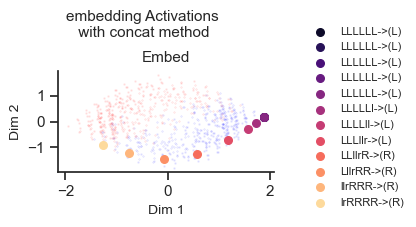

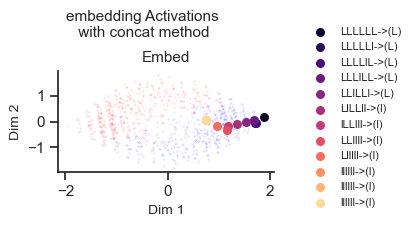

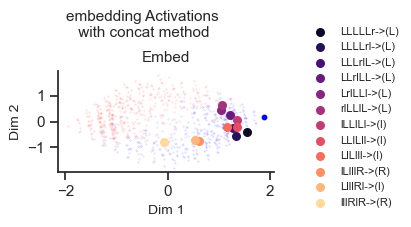

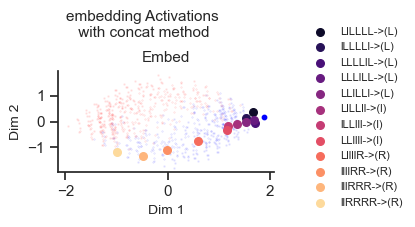

In [137]:
for i in range(10, 14):
    fig, axs = analyzer.plot_pca_across_trials(activations, sequences, block_sequences[i], 'embed', dr_config)

In [127]:
events, sequences, counts = interp.get_common_sequences(T, events=events, k=1000)
activations = analyzer.get_activations(sequences)
last_pos_by_layer = analyzer.get_activation_by_position(activations, token_pos=-1)

In [128]:
# Find maximal activations for each layer
max_activations = {}
for layer_name in analyzer.layers:
    max_activations[layer_name] = analyzer.find_maximal_activations(
        last_pos_by_layer, layer_name, sequences)
    
    # Print example results for a few neurons
    print(f"\n{layer_name.upper()} LAYER - Top activating sequences:")
    for neuron_idx in range(min(5, len(max_activations[layer_name]))):  # Show first 5 neurons
        print(f"Neuron {neuron_idx}: ", end="")
        for seq, act in max_activations[layer_name][neuron_idx][:5]:
            print(f"{seq} ({act:.3f})", end=" | ")
        print()


EMBED LAYER - Top activating sequences:
Neuron 0: RRRRRR (0.624) | RRRRrR (0.624) | RRRrRR (0.624) | RRrRRR (0.624) | RrRRRR (0.624) | 
Neuron 1: RRRRRR (0.425) | RRRRrR (0.425) | RRRrRR (0.425) | RRrRRR (0.425) | RrRRRR (0.425) | 
Neuron 2: LLLLLL (0.427) | LLLLlL (0.427) | LLLlLL (0.427) | LLlLLL (0.427) | LlLLLL (0.427) | 
Neuron 3: LLLLLL (0.182) | LLLLlL (0.182) | LLLlLL (0.182) | LLlLLL (0.182) | LlLLLL (0.182) | 


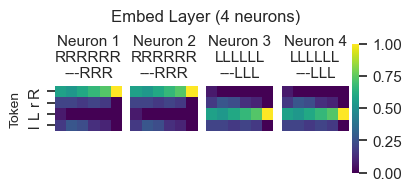

In [ ]:
fig, axes_dict = analyzer.create_mlp_visualization()

for neuron_idx, ax in enumerate(axes_dict['embed']):
    ax, token_counts = analyzer.analyze_neuron_patterns(max_activations, layer_name, neuron_idx, verbose=False,
                                                        ax=ax, cbar=neuron_idx == (len(axes_dict['embed'])-1))
    avg_sequence = analyzer.get_average_sequence(token_counts, single_threshold=0, joint_threshold=0)
    avg_sequence_thresholded = analyzer.get_average_sequence(token_counts, single_threshold=0.6, joint_threshold=0.4)
    ax.set(title=f"Neuron {neuron_idx+1}\n{avg_sequence}\n{avg_sequence_thresholded}", xticks=[])
    ax.set_aspect(1)
    if neuron_idx > 0:
        ax.set(ylabel='', yticks=[])
    ax.set(xlabel='')
